**Reference:** A.E. Raftery and V.E. Akman (1986) Bayesian analysis of a Poisson process with a change point. Biometrika, 73.1 pp.85-9

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Bayesian Stochastic Modelling Library
import pymc3 as pm

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
trucks = pd.read_csv('test.csv')
trucks.head(3)

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24,night,day
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


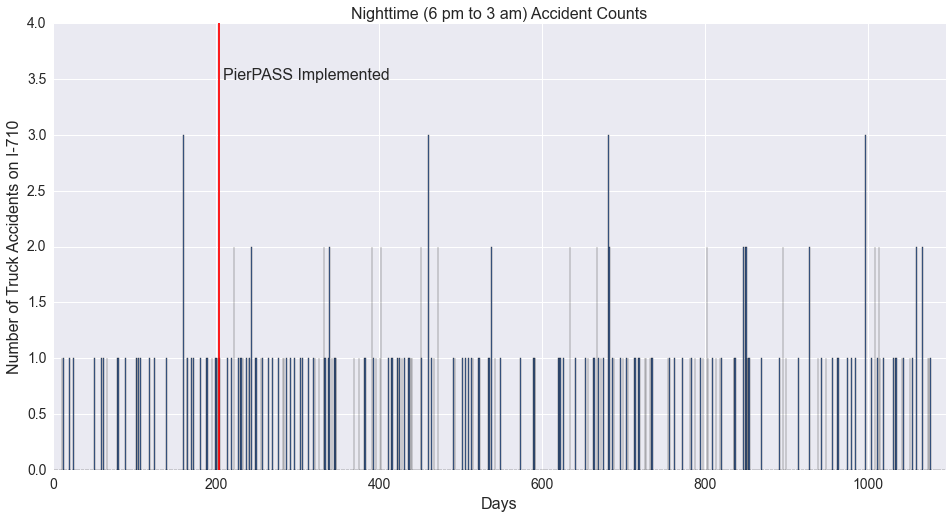

In [3]:
fig = plt.figure(figsize = (16, 8))
plt.bar(range(len(trucks)), trucks['night'])
plt.xlim(0, len(trucks))
plt.ylim(0, 4)
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Number of Truck Accidents on I-710', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 14)
# Plotting PierPASS implementation
plt.axvline(x = 204, color = 'r')
plt.text(204 + 5, 3.5, 'PierPASS Implemented', fontsize = 16)
plt.title('Nighttime (6 pm to 3 am) Accident Counts', fontsize = 16)

**Objective: Identify the change point in the time series which relates to increase in truck accidents after the implementation of PierPASS policy**

**Data:** Time series of recorded daily nighttime (6pm to 3 am) truck accident counts on I-710 Freeway (January 1, 2005 to December 31, 2007). 

Accidents (e.g. Traffic collisions, Earthquakes, etc.) are Poission distributed. Let random variable $X$ denote accident count, then probability mass function of $X$ is given by:

$$P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

Where, $K = 0, 1, ...$; rate parameter $\lambda > 0$ and $\lambda = E(X) = Var(X)$  
- Increasing $\lambda$ adds more probability to larger outcomes occuring
- Decreasing $\lambda$ adds more probability to smaller outcomes occuring  

In reality $\lambda$ is unknown or unobserved, only random events (accidents) are observed. $\lambda$ needs to be estimated.

From the plot above, it appears that accident rate might be higher after the implementation of PierPASS policy. Let's assume that on some day ($\tau$), the accident rate suddenly jumps to a higher value (i.e. a smaller rate parameter in the early part of the time series and a larger rate parameter in the later part of the time series). Thus,
- If $t < \tau$, then $\lambda = \lambda_e$
- If $t \geq \tau$, then $\lambda = \lambda_l$
where $t \in [t_l, t_u]$


**Bayesian Inference:** 

- Assign *prior* probabilities to $\lambda_e$ and $\lambda_e$
- Rate parameter $\lambda > 0$, i.e. any positive number
- Exponential distribution provides a continuous density function for positive numbers ($f(x) = \lambda e^{-\lambda x}$)

Assigning priors to accident rate parameters:

$$\lambda_e \sim Exp(r_e)$$
$$\lambda_l \sim Exp(r_l)$$

Two priors with different rate parameters ($r_e$ and $r_l$) reflects prior belief that accident rate changed at some point in the time series.

Assigning prior to switchpoint ($\tau$)
Accident count data is noisy, so it is difficult to pick out a priori when switchpoint ($\tau$) might have occured. Thus assign a uniform prior belief to each possible day, i.e.

$$\tau \sim DiscreteUniform(t_l, t_u)$$ 

**Statistical Model**

$$(Accident_t|\lambda_e, \lambda_l, \tau) \sim Poisson(\lambda_t)$$
   - If $t < \tau$, then $\lambda_t = \lambda_e$
   - If $t \geq \tau$, then $\lambda_t = \lambda_l$  

$$\lambda_e \sim Exponential(r_e)$$
$$\lambda_l \sim Exponential(r_l)$$
$$\tau \sim Discrete Uniform(t_l, t_u)$$ 
 

where:  
- $Accident_t$ is the number of truck accidents on day $t$
- $\lambda_t$ is the rate parameter of the Poisson distribution of truck accidents on day $t$  
- $\lambda_e$ is the rate parameter before the switchpoint $\tau$  
- $\lambda_l$ is the rate parameter after the switchpoint $\tau$
- $r_e, r_l$ are the rate parameters of the priors of the early and late rates, respectively 
- $\tau$ is the day on which the rate parameter changes (the switchpoint)
- $t_l, t_u$ are the lower and upper boundaries of days $t$  


In [4]:
accident_array = np.array(trucks['night'])
accident_array

array([0, 0, 0, ..., 0, 0, 0])

> PyMC3

Posterior $\propto$ Likelihood x Prior

$$P(\lambda_e, \lambda_l, \tau|Accident_t) \propto P(Accident_t|\lambda_e, \lambda_l, \tau) P(\lambda_e|\tau, r_e) P(r_e) P(\lambda_l|\tau, r_l) P(r_l) P(\tau)$$ 

$$P(\lambda_e, \lambda_l, \tau|Accident_t) = \iiint (Complicated Function)$$

Markov Chain Monte Carlo Algorithm returns samples from the posterior distributions of $\lambda_e$, $\lambda_l$ and $\tau$

In [5]:
with pm.Model() as model:
    # Prior for distribution of switchpoint location
    switchpoint = pm.DiscreteUniform('switchpoint', lower = 0, upper = len(accident_array))
    # Priors for pre- and post-switch mean number of accidents
    early_mean = pm.Exponential('early_mean', lam = 1.0)
    late_mean = pm.Exponential('late_mean', lam = 1.0)
    
    # Allocate appropriate poisson rates to days before and after current switchpoint location
    idx = np.arange(len(accident_array))
    rate = pm.switch(switchpoint >= idx, early_mean, late_mean)
    
    # Data likelihood
    accidents = pm.Poisson('accidents', rate, observed = accident_array)
    
    # Markov Chain Monte Carlo sampling
    # Initial value
    start = {'early_mean': 0.5, 'late_mean':1.0}
    
    # Using "Slice" sampler for means
    step1 = pm.Slice([early_mean, late_mean])
    
    # Using "Metropolis" for switchpoint, since it accomodates discrete variables
    step2 = pm.Metropolis([switchpoint])
    
    trace = pm.sample(1000, start = start, step = [step1, step2], progressbar = True)
    

 [-----------------100%-----------------] 1001 of 1000 complete in 1492.7 sec

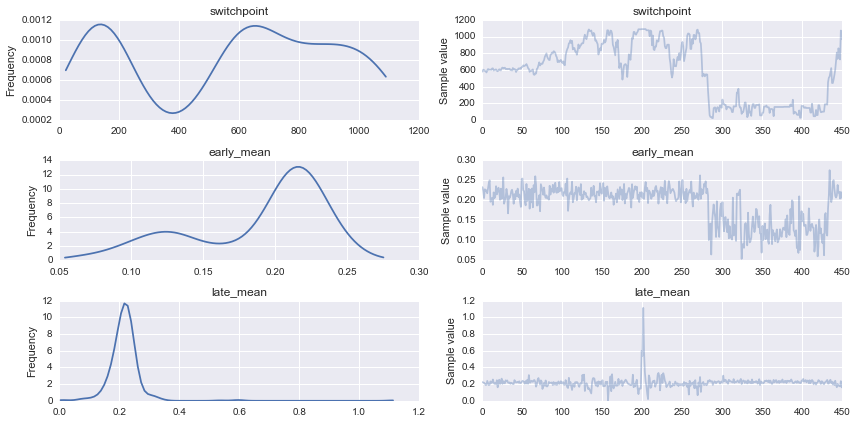

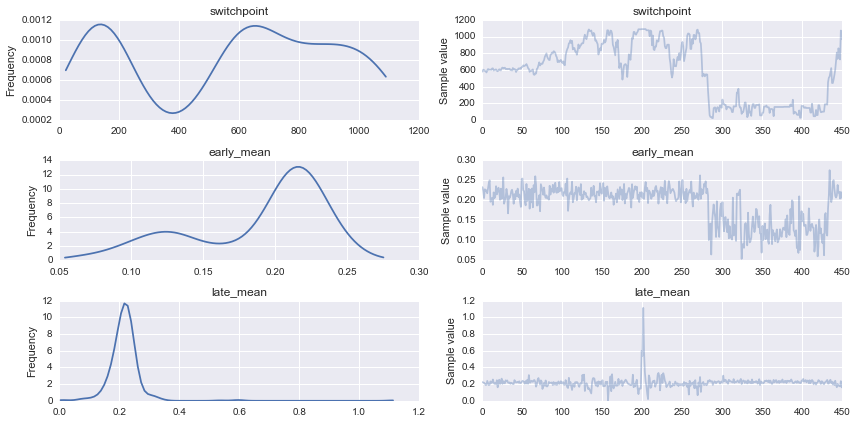

In [6]:
# Check the results
burn_in = 100 # Posterior samples to discard
thin = 2 # Posterior samples to discard

# Plot Kernal Density Estimates and sampled values for each parameter
pm.traceplot(trace[burn_in::thin])

In [7]:
print trace.varnames
early_mean_samples = trace['early_mean'][:]
late_mean_samples = trace['late_mean'][:]
switchpoint_samples = trace['switchpoint'][:]

['switchpoint', 'early_mean', 'late_mean']


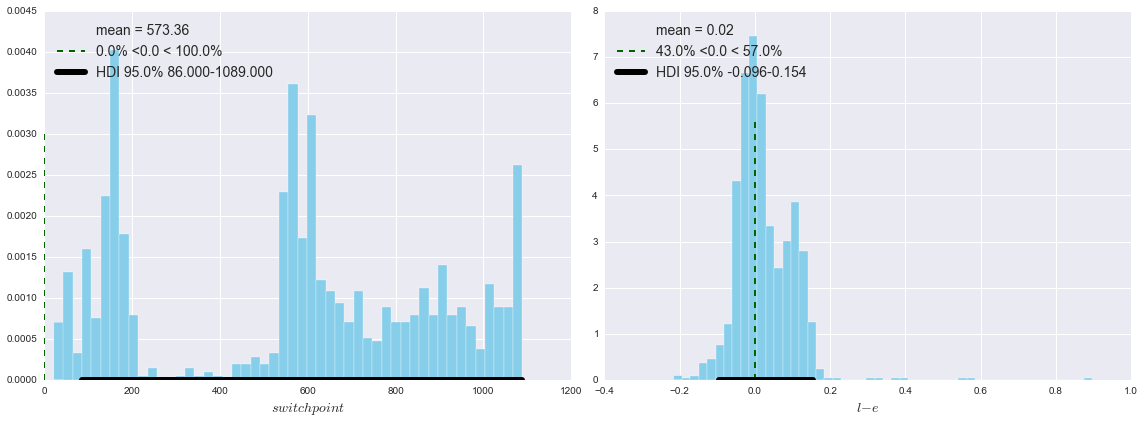

In [8]:
from plot_post import *

fig = plt.figure(figsize=(16, 6))

# Plot switchpoint
plt.subplot(1, 2, 1)
plot_post(switchpoint_samples, xlab=r'$switchpoint$', show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences among rate parameters
plt.subplot(1, 2, 2)
plot_post((late_mean_samples - early_mean_samples), xlab=r'$l-e$', show_mode=False, comp_val=0, framealpha=0.5)


plt.tight_layout()
plt.show()

95% HDI - There is 95% chance that the parameter of interest lies in this interval

Nature of MCMC algorithm -> Returned samples will exhibit autocorrelation

**Autocorrelation** is a measure of how related a series of numbers is with itself, i.e. If you know the position of series at time $t$, can this help you to know the position of series at time $t'$?

Example:
- $x_t \sim N(0, 1)$ -> No autocorrelation
- $y_t \sim N(y_{t-1}, 1), y_0 = 0$ -> Autocorrelation

As lag between time points increases autocorrelation decreases

- Thinning - Autocorrelation can be reduced by returning nth sample

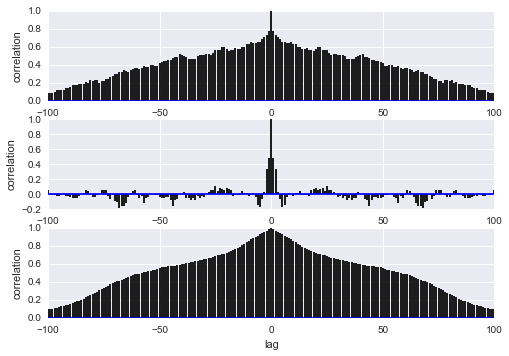

In [10]:
## Check for mixing and autocorrelation
pm.autocorrplot(trace[burn_in::thin], vars =[early_mean, late_mean, switchpoint])

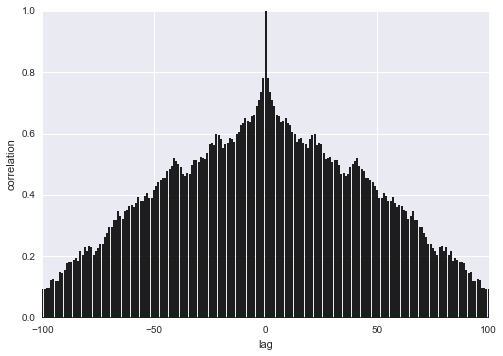

In [12]:
pm.autocorrplot(trace[burn_in::thin], vars =[early_mean])

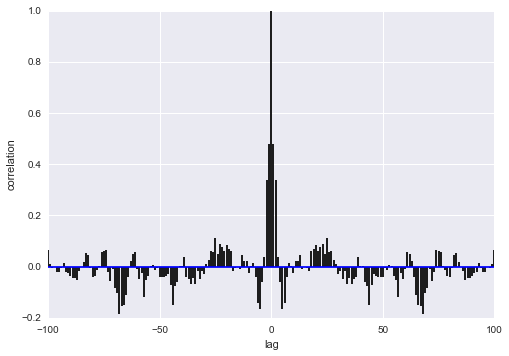

In [13]:
pm.autocorrplot(trace[burn_in::thin], vars =[late_mean])

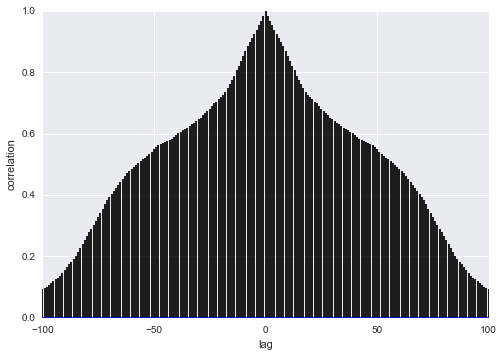

In [14]:
pm.autocorrplot(trace[burn_in::thin], vars =[switchpoint])